# EPICS4 PV access example

Outside of this Jupyter notebook
- start the GUI, which will start the P4P server
```bash
$ python scripts/devGui.py --ip <RFSOC_IP_ADDDRESS> --boardType <BOARD_TYPE> --bpmFreqMHz <BPM_FREQ>
```

In [1]:
# setup the P4P client
# https://mdavidsaver.github.io/p4p/client.html#usage
import numpy as np
import time
import matplotlib.pyplot as plt
from p4p.client.thread import Context
print( Context.providers() )
ctxt = Context('pva')

# Some useful pointers to reduce string lengths
Root = 'kek_bpm_rfsoc_demo_ioc:Root'
AxiVersion  = f'{Root}:RFSoC:AxiSocCore:AxiVersion'
ReadoutCtrl = f'{Root}:RFSoC:Application:ReadoutCtrl'
AdcDispProcessor  = [ f'{Root}:AdcDispProcessor[{i}]'  for i in range(4)]
AmpDispProcessor  = [ f'{Root}:AmpDispProcessor[{i}]'  for i in range(4)]
AmpFaultProcessor = [ f'{Root}:AmpFaultProcessor[{i}]' for i in range(4)]
BpmDispProcessor = f'{Root}:BpmDispProc'
BpmFaultProcessor = f'{Root}:BpmFaultProc'

['pva']


In [2]:
# Get the FPGA firmware Version
# https://github.com/slaclab/darpa-accel-llrf-phase-1p5/blob/main/firmware/targets/shared_version.mk#L2
hex(ctxt.get( f'{AxiVersion}:FpgaVersion' ))

'0x6030000'

In [3]:
# Put/Get the debug scratch pad
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L47
ctxt.put( f'{AxiVersion}:ScratchPad', 0x12345678 )
hex(ctxt.get( f'{AxiVersion}:ScratchPad' ))

'0x12345678'

In [4]:
# Get the UpTimeCnt (units of seconds) 
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L58
ctxt.get( f'{AxiVersion}:UpTimeCnt' )

43

In [5]:
# Get the UpTime ('HH:MM:SS')
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L80
ctxt.get( f'{AxiVersion}:UpTime' )

'0:00:43'

In [6]:
# Get the GitHash
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L179
ctxt.get( f'{AxiVersion}:GitHash' )

'0xd9581e437b9687c6692f2ec7b5e018075f14a35f'

# Position display

In [12]:
def TrigRingBuffer(trigType='liveDisplay'):

    if trigType=='liveDisplay':
        ctxt.put(  f'{BpmDispProcessor}:RxEnable', 1)
        ctxt.put(  f'{BpmDispProcessor}:Updated', 0)        
        ctxt.put( f'{ReadoutCtrl}:LiveDispTrigRaw', 1)
        #ctxt.rpc( f'{ReadoutCtrl}:LiveDispTrig')
        # Wait for Waveform
        while ( ctxt.get( f'{BpmDispProcessor}:Updated') != True):
            time.sleep(0.01)
            
        for i in range(4):
            ctxt.put(  f'{AdcDispProcessor[i]}:RxEnable', 1)
            ctxt.put(  f'{AmpDispProcessor[i]}:RxEnable', 1)             
            ctxt.put(  f'{AdcDispProcessor[i]}:Updated', 0)
            ctxt.put(  f'{AmpDispProcessor[i]}:Updated', 0)        
        ctxt.put( f'{ReadoutCtrl}:LiveDispTrigRaw', 1)
        #ctxt.rpc( f'{ReadoutCtrl}:LiveDispTrig')
        for i in range(4):
            # Wait for Waveform
            while ( ctxt.get( f'{AdcDispProcessor[i]}:Updated') != True):
                time.sleep(0.01)
            while ( ctxt.get( f'{AmpDispProcessor[i]}:Updated') != True):
                time.sleep(0.01)  
    
    elif trigType=='faultDisplay':
        ctxt.put(  f'{BpmFaultProcessor}:RxEnable', 1) 
        ctxt.put(  f'{BpmFaultProcessor}:Updated', 0)  
        ctxt.put( f'{ReadoutCtrl}:SwFaultTrigRaw', 1)
        # ctxt.rpc( f'{ReadoutCtrl}:SwFaultTrig')
        # Wait for Waveform
        while ( ctxt.get( f'{BpmFaultProcessor}:Updated') != True):
            time.sleep(0.01) 
        for i in range(4):
            ctxt.put(  f'{AmpFaultProcessor[i]}:RxEnable', 1)               
            ctxt.put(  f'{AmpFaultProcessor[i]}:Updated', 0)         
        ctxt.put( f'{ReadoutCtrl}:SwFaultTrigRaw', 1)
        # ctxt.rpc( f'{ReadoutCtrl}:SwFaultTrig')
        for i in range(4):
            # Wait for Waveform
            while ( ctxt.get( f'{AmpFaultProcessor[i]}:Updated') != True):
                time.sleep(0.01)  
    
    else:
        print('Error: TrigRingBuffer.trigType={trigType} is not supported')

# Function to plot the ADC/DAC waveforms
def BPMPlotWavform(plotType='liveDisplay',dataType='Xposition',xMin=0,xMax=20):

    if plotType=='liveDisplay':
        if dataType=='Xposition':
            xData = ctxt.get(f'{BpmDispProcessor}:Time')
            yData = ctxt.get(f'{BpmDispProcessor}:Xposition')
        elif dataType=='Yposition':
            xData = ctxt.get(f'{BpmDispProcessor}:Time')
            yData = ctxt.get(f'{BpmDispProcessor}:Yposition')
        elif dataType=='BunchCharge':
            xData = ctxt.get(f'{BpmDispProcessor}:Time')
            yData = ctxt.get(f'{BpmDispProcessor}:BunchCharge')
        else:
            print('Error: PlotWavform.dataType={dataType} is not supported')
            
    
    elif plotType=='faultDisplay':
        if dataType=='Xposition':
            xData = ctxt.get(f'{BpmFaultProcessor}:Time')
            yData = ctxt.get(f'{BpmFaultProcessor}:Xposition')
        elif dataType=='Yposition':
            xData = ctxt.get(f'{BpmFaultProcessor}:Time')
            yData = ctxt.get(f'{BpmFaultProcessor}:Yposition')
        elif dataType=='BunchCharge':
            xData = ctxt.get(f'{BpmFaultProcessor}:Time')
            yData = ctxt.get(f'{BpmFaultProcessor}:BunchCharge')
        else:
            print('Error: PlotWavform.dataType={dataType} is not supported')
    else:
        print('Error: PlotWavform.plotType={trigType} is not supported')

    plt.plot(xData,yData)
    plt.xlim(xMin,xMax)
    plt.xlabel( 'Time (ns)' )
    if dataType=='BunchCharge':
        plt.ylabel( f'{dataType} (Counts)' )
    else:
        plt.ylabel( f'{dataType} (mm)' )
    plt.show()

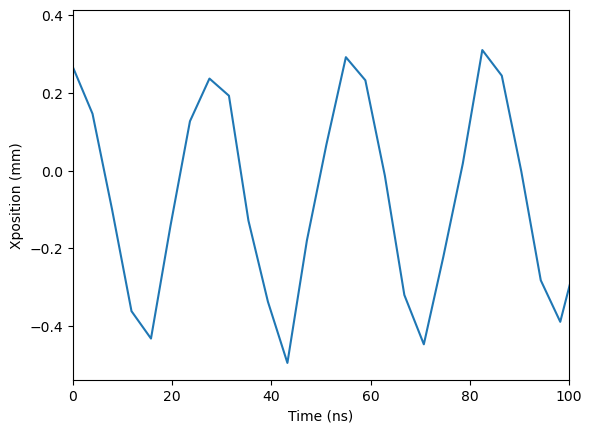

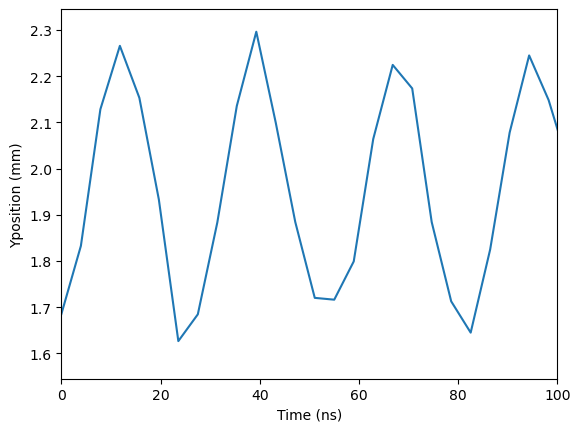

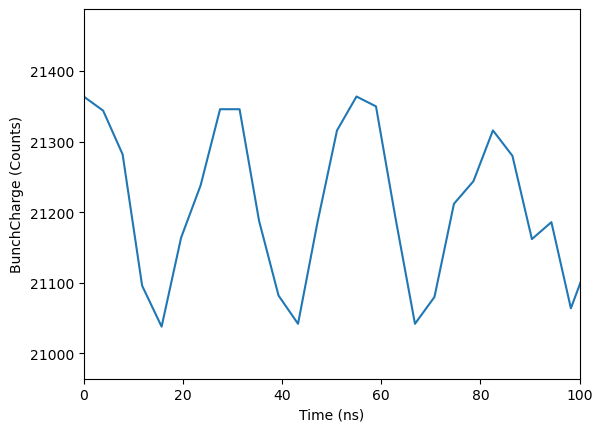

In [13]:
# Trigger the Live display
TrigRingBuffer(trigType='liveDisplay')

# Plot Xposition[CH=2]
BPMPlotWavform(plotType='liveDisplay',dataType='Xposition',xMin=0,xMax=100)

# Plot Xposition[CH=2]
BPMPlotWavform(plotType='liveDisplay',dataType='Yposition',xMin=0,xMax=100)

# Plot Charge[CH=2]
BPMPlotWavform(plotType='liveDisplay',dataType='BunchCharge',xMin=0,xMax=100)

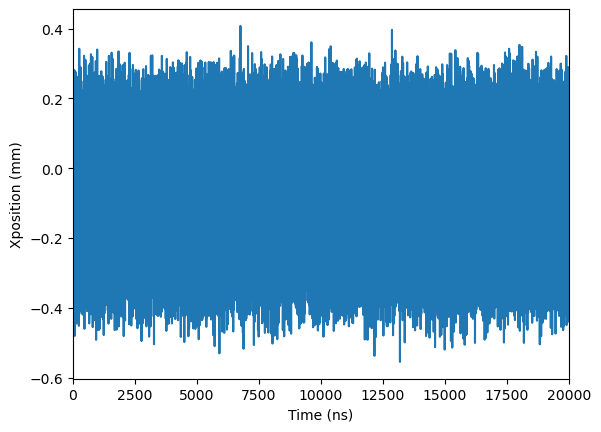

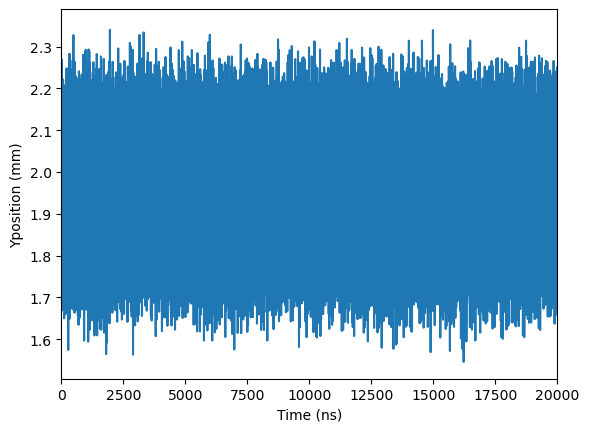

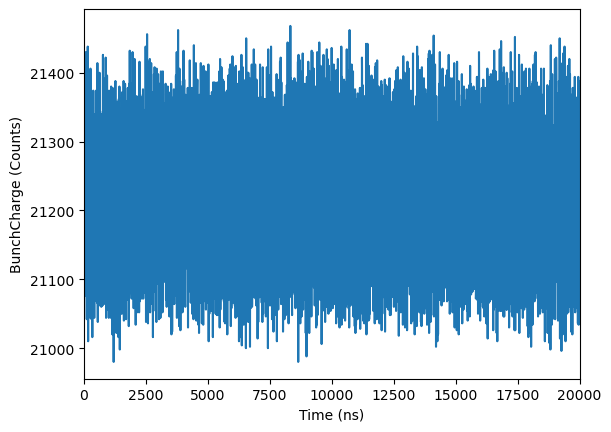

In [14]:
# Trigger the Fault display
TrigRingBuffer(trigType='faultDisplay')

# Plot Xposition[CH=2]
BPMPlotWavform(plotType='faultDisplay',dataType='Xposition',xMin=0,xMax=20.0E+3)

# Plot Xposition[CH=2]
BPMPlotWavform(plotType='faultDisplay',dataType='Yposition',xMin=0,xMax=20.0E+3)

# Plot Charge[CH=2]
BPMPlotWavform(plotType='faultDisplay',dataType='BunchCharge',xMin=0,xMax=20.0E+3)

# ADC and AMP display

In [10]:
# Function to plot the ADC/DAC waveforms
def PlotWavform(plotType='liveDisplay',dataType='Amp',ch=0,xMin=0,xMax=20):

    if plotType=='liveDisplay':
        if dataType=='Adc':
            xData = ctxt.get(f'{AdcDispProcessor[ch]}:Time')
            yData = ctxt.get(f'{AdcDispProcessor[ch]}:WaveformData')
        else:
            xData = ctxt.get(f'{AmpDispProcessor[ch]}:Time')
            yData = ctxt.get(f'{AmpDispProcessor[ch]}:WaveformData')               
    
    elif plotType=='faultDisplay':
        xData = ctxt.get(f'{AmpFaultProcessor[ch]}:Time')
        yData = ctxt.get(f'{AmpFaultProcessor[ch]}:WaveformData')            
    else:
        print('Error: PlotWavform.plotType={trigType} is not supported')

    plt.plot(xData,yData)
    plt.xlim(xMin,xMax)
    plt.xlabel( 'Time (ns)' )
    plt.ylabel( f'{dataType}[ch={ch}] (Counts)' )
    plt.show()

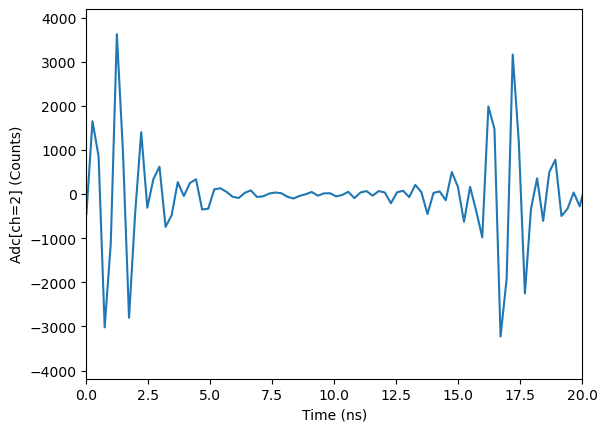

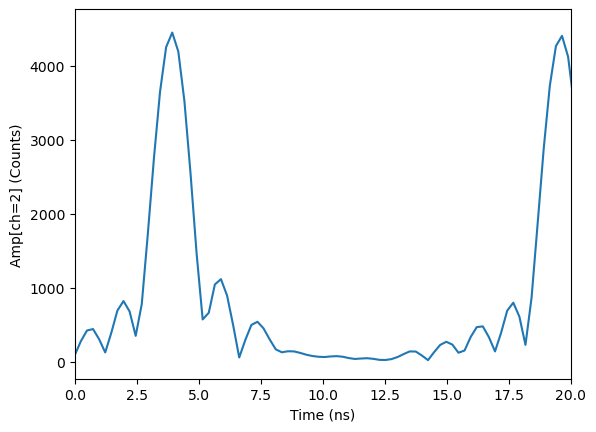

In [11]:
# Trigger the Live display
TrigRingBuffer(trigType='liveDisplay')

# Plot ADC[CH=2]
PlotWavform(plotType='liveDisplay',dataType='Adc',ch=2,xMin=0,xMax=20)

# Plot AMP[CH=2]
PlotWavform(plotType='liveDisplay',dataType='Amp',ch=2,xMin=0,xMax=20)

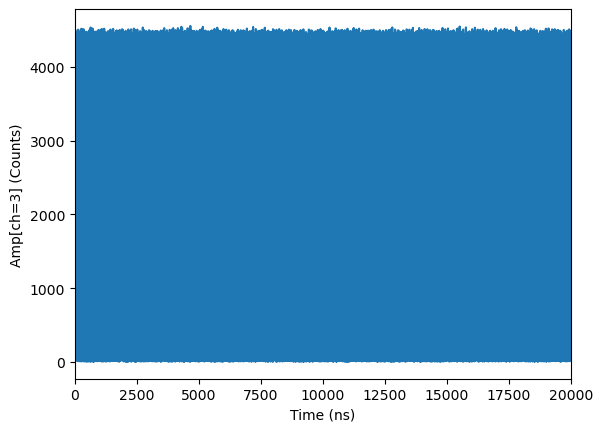

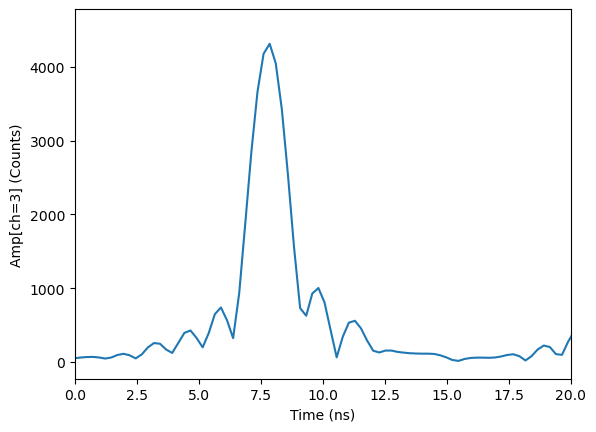

In [12]:
# Trigger the Fault display
TrigRingBuffer(trigType='faultDisplay')

# Plot ADC[CH=2] for 20 us
PlotWavform(plotType='faultDisplay',dataType='Amp',ch=3, xMin=0, xMax=20.0E+3)

# Plot ADC[CH=2] for 20 ns
PlotWavform(plotType='faultDisplay',dataType='Amp',ch=3, xMin=0, xMax=20)

# Latency check
use config/DacPatterns/SinglePulse.csv

and set 'EnableSoftTrig' to False

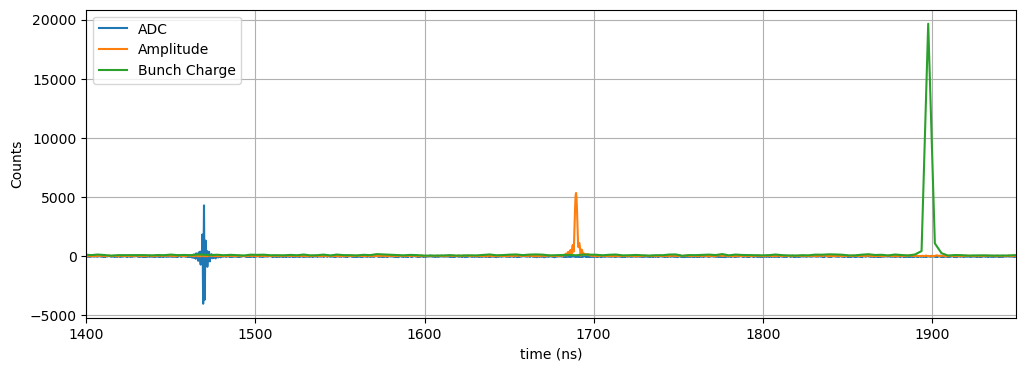

In [16]:
ch=0
x_adc = ctxt.get(f'{AdcDispProcessor[ch]}:Time')
y_adc = ctxt.get(f'{AdcDispProcessor[ch]}:WaveformData')
x_amp = ctxt.get(f'{AmpDispProcessor[ch]}:Time')
y_amp = ctxt.get(f'{AmpDispProcessor[ch]}:WaveformData')
x_charge = ctxt.get(f'{BpmDispProcessor}:Time')
y_charge = ctxt.get(f'{BpmDispProcessor}:BunchCharge') 

plt.figure(figsize=(12,4))
plt.plot(x_adc,y_adc,label='ADC')
plt.plot(x_amp,y_amp,label='Amplitude')
plt.plot(x_charge,y_charge,label='Bunch Charge')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.grid()
plt.legend()
plt.xlim(1400,1950)
#plt.savefig('latency.png',dpi=150)
plt.show()